In [1]:
import deorbit
import matplotlib.pyplot as plt
import deorbit.data_models
from deorbit.predictor.EKF import EKF
from deorbit.utils.dataio import load_sim_data, load_sim_config
import numpy as np
from deorbit.simulator.atmos import AtmosphereModel

In [2]:
save_path = "eg/EKF_example_1/"

sim_data = load_sim_data(save_path)
sim_config = load_sim_config(save_path)

if sim_data is None or sim_config is None:
    sim = deorbit.simulator.run(
        "adams_bashforth",
        "coesa_atmos_fast",
        initial_state=np.array((deorbit.constants.EARTH_RADIUS + 150000, 0, 0, 7820)),
        time_step=0.1,
    )
    sim_data = sim.gather_data()
    sim_config = sim.export_config()
    sim.save_data(save_path)
else:
    print("Loaded data from file")

Running simulation with Two-step Adams-Bashforth integrator without noise
Ran 262728 iterations at time step of 0.1 seconds
Impacted at [ 6168983.59022696 -1591617.34648274] at velocity [-48.10422636  12.41104308] at simulated time 26272.89999989817s.
Simulation finished in 22.47789 seconds


In [3]:
# Define process and measurement noise covariance matrices, think this noise should be alot bigger
Q = np.diag([0.1, 0.1, 0.01, 0.01])
R = np.diag([1, 1, 0.1, 0.1])
P = np.diag([1, 1, 1, 1])

# Measurement matrix H (assuming all states are measured directly??????) -- for now
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])

dt = sim_config.simulation_method_kwargs.time_step
atmos_config = sim_config.atmosphere_model_kwargs

atmos = AtmosphereModel(atmos_config)

estimated_traj, measurements = EKF(sim_data, sim_config, atmos, dt, Q, R, P, H)

[[ 6.52100000e+06  0.00000000e+00  0.00000000e+00  7.82000000e+03]
 [ 6.52100000e+06  7.82000000e+02 -9.37366385e-01  7.81999996e+03]
 [ 6.52099986e+06  1.56399999e+03 -1.87473273e+00  7.81999975e+03]]
[[ 6.52099979e+06  2.49217412e-02  3.75535318e-01  7.81991873e+03]
 [ 6.52099910e+06  7.82832464e+02 -6.90313816e-01  7.82015845e+03]
 [ 6.52100158e+06  1.56189394e+03 -1.93313465e+00  7.82042479e+03]]
[array([6.52099979e+06, 2.49217412e-02, 3.75535318e-01, 7.81991873e+03])]


100%|██████████| 262729/262729 [01:21<00:00, 3235.37it/s]


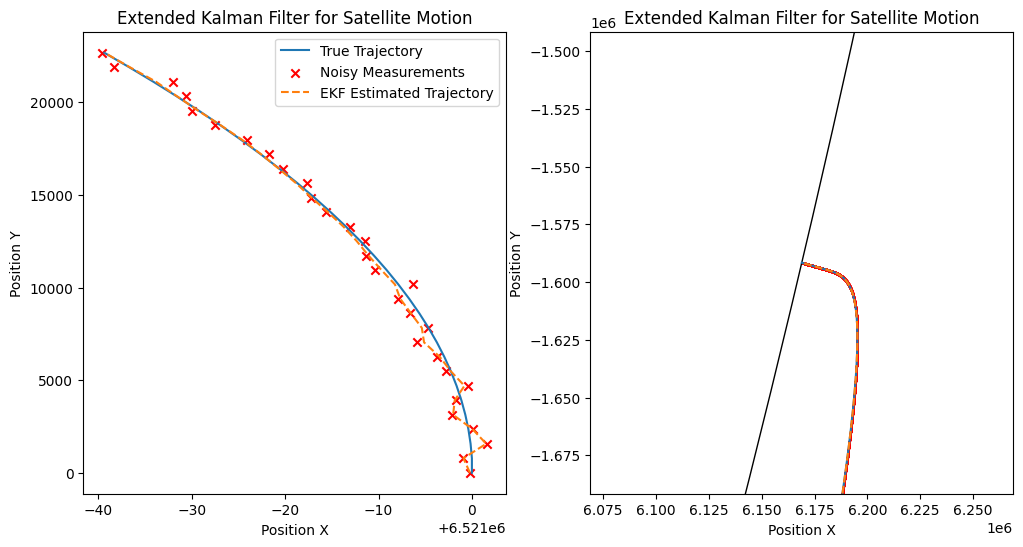

In [4]:
true_traj = sim_data.state_array()[:, :2]

crash_coords = true_traj[-1, :]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))

plot_range = slice(0, 30)

ax1.plot(true_traj[:, 0][plot_range], true_traj[:, 1][plot_range], label='True Trajectory')
ax1.scatter(measurements[:, 0][plot_range], measurements[:, 1][plot_range], marker='x', color='r', label='Noisy Measurements')
ax1.plot(estimated_traj[:, 0][plot_range], estimated_traj[:, 1][plot_range], label='EKF Estimated Trajectory', linestyle='--')
ax1.set_title('Extended Kalman Filter for Satellite Motion')
ax1.set_xlabel('Position X')
ax1.set_ylabel('Position Y')



ax2.plot(true_traj[:, 0], true_traj[:, 1], label='True Trajectory')
ax2.scatter(measurements[:, 0], measurements[:, 1], marker='x', color='r', label='Noisy Measurements', s=1)
ax2.plot(estimated_traj[:, 0], estimated_traj[:, 1], label='EKF Estimated Trajectory', linestyle='--')
ax2.set_title('Extended Kalman Filter for Satellite Motion')
ax2.set_xlabel('Position X')
ax2.set_ylabel('Position Y')
ax2.set_xlim([crash_coords[0]-1e5, crash_coords[0]+1e5])
ax2.set_ylim([crash_coords[1]-1e5, crash_coords[1]+1e5])
earth = plt.Circle((0, 0), radius=deorbit.constants.EARTH_RADIUS, fill=False)
ax2.add_patch(earth)
ax1.legend()

plt.show()